<a href="https://colab.research.google.com/github/Anderson1292/Artificial_intelligence/blob/main/notebooks/Serie_temporal_com_multiplos_previsores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [ ]:
base = pd.read_csv('petr4_treinamento.csv')
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [ ]:
base = base.dropna()

In [ ]:
base_train = base.iloc[:,1:7].values

In [ ]:
#Normalization of values
normalized = MinMaxScaler(feature_range=(0,1))
base_train_norm = normalized.fit_transform(base_train)

In [ ]:
normalized_predictors = MinMaxScaler(feature_range=(0,1))
normalized_predictors.fit_transform(base_train[:,0:1])

In [ ]:
predictors = []
real_price = []

for i in range(90,1242):
  predictors.append(base_train_norm[i-90:i,0:6])
  real_price.append(base_train_norm[i,0])
predictors,real_price = np.array(predictors),np.array(real_price)

In [ ]:
model = Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(predictors.shape[1],6)))
model.add(Dropout(0.25))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.25))

model.add(LSTM(50))
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mean_absolute_error'])

In [ ]:
# model.fit(predictors,real_price,epochs=100,batch_size=32)
early = EarlyStopping(monitor='loss',min_delta=1e-10,patience=10,verbose=1)
reduce = ReduceLROnPlateau(monitor='loss',factor=0.2,patience=5,verbose=1)
model_check = ModelCheckpoint(filepath='weights.h5',monitor='loss',save_best_only=True,verbose=1)

In [ ]:
model.fit(predictors,real_price,epochs=100,batch_size=32,
          callbacks=[early,reduce,model_check])

Epoch 1/100
34/36 [===========================>..] - ETA: 0s - loss: 0.0189 - mean_absolute_error: 0.1078
Epoch 1: loss improved from inf to 0.01810, saving model to weights.h5
36/36 [==============================] - 10s 21ms/step - loss: 0.0181 - mean_absolute_error: 0.1047 - lr: 0.0010
Epoch 2/100
34/36 [===========================>..] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0670
Epoch 2: loss improved from 0.01810 to 0.00773, saving model to weights.h5
36/36 [==============================] - 1s 20ms/step - loss: 0.0077 - mean_absolute_error: 0.0693 - lr: 0.0010
Epoch 3/100
34/36 [===========================>..] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.0597
Epoch 3: loss improved from 0.00773 to 0.00580, saving model to weights.h5
36/36 [==============================] - 1s 19ms/step - loss: 0.0058 - mean_absolute_error: 0.0593 - lr: 0.0010
Epoch 4/100
34/36 [===========================>..] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.0521
Epoch 4: loss impr

In [ ]:
#Refazendo os mesmos passos para o aquivo de teste
base_test = pd.read_csv('petr4_teste.csv')
base_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000


In [ ]:
real_price_teste = base_test.iloc[:,1:2].values

In [ ]:
frames = [base,base_test]
base_complet = pd.concat(frames)

In [ ]:
base_complet = base_complet.drop('Date',axis=1)

In [ ]:
outputs = base_complet[len(base_complet) - len(base_test) - 90:].values

In [ ]:
outputs = normalized.transform(outputs)

In [ ]:
X_test = []
for i in range(90,112):
  X_test.append(outputs[i-90:i,0:6])
X_test = np.array(X_test)

In [ ]:
predictors_tst = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [ ]:
predictors_tst = normalized_predictors.inverse_transform(predictors_tst)

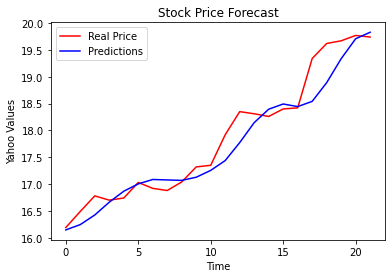

In [ ]:
plt.plot(real_price_teste,color='red',label='Real Price')
plt.plot(predictors_tst,color='blue',label='Predictions')
plt.title('Stock Price Forecast')
plt.xlabel('Time')
plt.ylabel('Yahoo Values')
plt.legend()
plt.show()